This notebook is a simple example for how to approach the Euro 2020 prediction competition. It should provide a guide for preparing a dataset, fitting a simple model and making predictions using that model. It wouldn't score very highly if actually submitted for the competition, but I've tried to give some indication for why this is the case and, at the very least, should get your juices flowing for how you want to attack the problem!

Enjoy!


In [1]:
#I use a combination of pandas, numpy, scipy and statsmodels, but the choice of package is yours! 

import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import poisson

# Data

I'm going to be using the international football results data from Kaggle. It can be found at https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017 

Choosing and sourcing the best dataset is a vital part of any modelling process. You can use a complicated, state-of-the-art modelling technique but, if you put garbage in, you get garbage out!

The kaggle page for the dataset provides a really nice exploration of the information available. It is always worth understanding what is ontained within a dataset before diving straight into modelling. I like the breadth of data available (international matches as far back as 1872) but the depth of information is slightly lacking. 

For my goal, which is to provide an example for how to get started with making predictions, this dataset is perfect! But, if I were looking to build a model with the best predictive power (perhaps for a certain competition), I'd ideally want a dataset containing more information about each match. 

For example, this dataset doesn't tell me the time of goals or if there were any red cards/injuries. A match in which a team goes 1-0 up, gets two players sent off and procedes to lose 6-1 likely contains different information to a match where a team scores a late consolation goal when already losing 6-0. These matches would look the same in the kaggle dataset. 

It would also be really valuable to have an understanding of the players taking part in each match. 

The choice of dataset is yours, I look forward to seeing what you find!

In [8]:
#I've saved the file in the same folder as my notebook. You might need to change the file path here...
data = pd.read_csv("results.csv")

NameError: name 'pd' is not defined

In [2]:
#Let's see what we're playing with. 
data.head(10)

NameError: name 'data' is not defined

In [3]:
#Looks like we start with a lot of games between the Home Nations. What about more recently
data.tail(10)

NameError: name 'data' is not defined

# A simple model

It is often assumed that home and away goals in football matches follow a poisson distribution. Let's test this assumption. I will find the mean of home and away goals and compare poisson distributions based on these parameters to the actual observed distribution of goals. 


In [4]:
f, axes = plt.subplots(2, 1)

home_mean =  data.home_score.mean()
x = np.arange(max(data.home_score)+1)
poisson_home_pred = poisson.pmf(x, home_mean)
axes[0].plot(x, poisson_home_pred, "r", marker='o', label = "Predicted")

home_goal_proportions = data.groupby("home_score").date.count()/len(data)
axes[0].plot(home_goal_proportions.index, home_goal_proportions.values, "b", marker='o', label = "Actual")
axes[0].set_title("Home Goals- mean {}".format(round(home_mean, 2)))
axes[0].set_xlabel("Number of Goals")
axes[0].set_ylabel("Proportions")
axes[0].legend()

away_mean =  data.away_score.mean()
x = np.arange(max(data.away_score)+1)
poisson_away_pred = poisson.pmf(x, away_mean)
axes[1].plot(x, poisson_away_pred, "r", marker='o', label = "Predicted")

away_goal_proportions = data.groupby("away_score").date.count()/len(data)
axes[1].plot(away_goal_proportions.index, away_goal_proportions.values, "b", marker='o', label = "Actual")
axes[1].set_title("Away Goals - mean {}".format(round(away_mean, 2)))
axes[1].set_xlabel("Number of Goals")
axes[1].set_ylabel("Proportions")
axes[1].legend()

f.tight_layout()
plt.show()



NameError: name 'plt' is not defined

The first thing that jumps out is that there are a few matches with more than 10 goals scored by one of the sides. You might want to do something about that...

I also notice in both plots that there are a larger number of matches with zero goals than the poisson model predicts and perhaps a few more matches in the 5-10 goal range. The Dixon and Coles [1997] paper gives some of an indication for why this might be. 

I certainly hope the best model's submitted for the competition will be a closer fit than the graphs above, but, for my purposes, I'm happy to procede. Indeed, it's always a good idea to start off with a simple model to use as a benchmark even if you know it misses some aspect of the underlying data. It's very easy to end up building more and more complicated models without checking whether predictive power is actually improving; a comparison to a simple benchmark is a valuable tool. 


# Adding some independent variables and simple cleaning of the data

It's clear in the above plots that the away team tends to score fewer goals than the home side and, with 42,082 matches in the data, I'm confident that this is statistically significant. It also matches conventional wisdom that home support provides an advantage to the home team (I will need to be slightly careful about matches played at neutral venues). It's also a fairly obvious fact that some teams are better than others and the model I am going to fit aims to incorporate these two ideas. 

I'm going to assume the number of goals scores by each team follows a poisson distribution and that the log of the expected number of goals depends on the attacking quality of the team in question, the defensive ability of their opponnents and whether the team is playing at home, away or a neutral venue.

That means I'm fitting a Poisson GLM with log link function. The independent variables are team name, opponent name and location (home/away/neutral). I have all of this information available to me for each match but I'm going to need to do a bit of manipulation of the data to get it into the format required by the statsmodels package. 

It also assumes that countries' defensive and attacking abilities have not changed over time but, I highly doubt that the Scotland and England sides that played in Glasgow in 1872 bear much resemblence to the current sides. I'll make a simple attempt to avoid this issue by filtering the data to matches this millenium. I'm also likely to hit issues if I include teams with not very many matches so I'll remove matches with teams who have played fewer than 100 internationals in this time period (checking that I don't lose any of the teams from this year's tournament of course). 

Be wary when throwing away information as recklessly as I'm doing here! It's worth finding a way to convince yourself you're not influencing your predictions in a negative way before doing something similar. 



In [6]:
#Data manipulaton
data["date"]=pd.to_datetime(data.date)
recent_data = data[data.date>=pd.to_datetime("2000-01-01")]


home_data = recent_data.copy()
home_data = home_data.rename(columns={"home_team":"team_name",
                              "away_team":"opp_name",
                             "home_score":"goals_scored",
                             })
home_data["location"]=np.where(home_data["neutral"],"neutral","home")
home_data = home_data[["date","goals_scored","team_name","opp_name","location"]]

away_data = recent_data.copy()
away_data = away_data.rename(columns={"away_team":"team_name",
                              "home_team":"opp_name",
                             "away_score":"goals_scored",
                             })
away_data["location"]=np.where(away_data["neutral"],"neutral","away")
away_data = away_data[["date","goals_scored","team_name","opp_name","location"]]

model_data = pd.concat([home_data,away_data])

display(model_data.head())
display(model_data.tail())

,date,goals_scored,team_name,opp_name,location
22464,2000-01-04,2,Egypt,Togo,home
22465,2000-01-07,7,Tunisia,Togo,home
22466,2000-01-08,0,Trinidad and Tobago,Canada,home
22467,2000-01-09,1,Burkina Faso,Gabon,home
22468,2000-01-09,1,Guatemala,Armenia,neutral


,date,goals_scored,team_name,opp_name,location
42079,2021-03-31,4,Hungary,Andorra,away
42080,2021-03-31,2,Albania,San Marino,away
42081,2021-03-31,2,Romania,Armenia,away
42082,2021-03-31,2,North Macedonia,Germany,away
42083,2021-03-31,4,Iceland,Liechtenstein,away


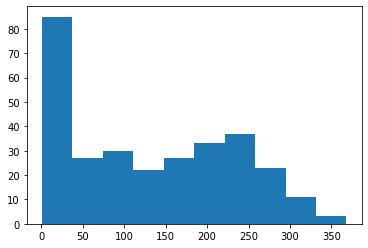

array(['Abkhazia', 'Afghanistan', 'Alderney', 'American Samoa',
       'Andalusia', 'Anguilla', 'Arameans Suryoye', 'Artsakh', 'Aruba',
       'Bahamas', 'Barawa', 'Basque Country', 'Belize', 'Bermuda',
       'Bhutan', 'Bonaire', 'British Virgin Islands', 'Brittany',
       'Brunei', 'Canary Islands', 'Cascadia', 'Catalonia',
       'Cayman Islands', 'Central African Republic', 'Chad',
       'Chagos Islands', 'Chameria', 'Chinese Taipei', 'Comoros',
       'Cook Islands', 'Corsica', 'County of Nice', 'Crimea', 'Darfur',
       'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor',
       'Ellan Vannin', 'Eritrea', 'Falkland Islands', 'Felvidék', 'Fiji',
       'French Guiana', 'Frøya', 'Galicia', 'Gambia', 'Gibraltar',
       'Gotland', 'Gozo', 'Greenland', 'Guam', 'Guernsey',
       'Guinea-Bissau', 'Găgăuzia', 'Hitra', 'Iraqi Kurdistan',
       'Isle of Man', 'Isle of Wight', 'Jersey', 'Kabylia', 'Kernow',
       'Kiribati', 'Kosovo', 'Kárpátalja', 'Macau', 'Madrid',
       'M

133

39240
32458


In [7]:

team_counts = model_data.groupby("team_name").goals_scored.count()
plt.hist(team_counts)
plt.show()

min_matches = 100
low_matches_teams = team_counts[team_counts<=min_matches].reset_index().team_name.unique()
display(low_matches_teams)
display(len(low_matches_teams))

filtered_model_data = model_data[~model_data.team_name.isin(low_matches_teams)&
                                 ~model_data.opp_name.isin(low_matches_teams)
                                ]

print(len(model_data))
print(len(filtered_model_data))

In [8]:
model = smf.glm("goals_scored ~  C(location) + C(team_name) + C(opp_name) - 1",
                data=filtered_model_data,
                family=sm.families.Poisson()
               )
fit = model.fit()
display(fit.null_deviance-fit.deviance)
display(fit.summary())



11298.494172022125

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           goals_scored   No. Observations:                32458
Model:                            GLM   Df Residuals:                    32127
Model Family:                 Poisson   Df Model:                          330
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -44472.
Date:                Wed, 14 Apr 2021   Deviance:                       35940.
Time:                        13:47:15   Pearson chi2:                 3.24e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
C(location)[away]                         -0.2848      0.098     -2.909      0.004      -0.477      -0.093
C(location)[home]                          0.1310      0.098      1.340      0.180      -0.061       0.323
C(location)[neutral]                      -0.0553      0.098     -0.563      0.574      -0.248       0.137
C(team_name)[T.Algeria]                    0.2729      0.095      2.872      0.004       0.087       0.459
C(team_name)[T.Andorra]                   -1.3782      0.172     -8.027      0.000      -1.715      -1.042
C(team_name)[T.Angola]                    -0.0959      0.100     -0.960      0.337      -0.292       0.100
C(team_name)[T.Antigua and Barbuda]       -0.5292      0.136     -3.882      0.000      -0.796      -0.262
C(team_name)[T.Argentina]                  0.9152      0.086     10.589      0.000       0.746       1.085
C(team_name)[T.Armenia]                    0.0964      0.101      0.955      0.340      -0.102       0.294
C(team_name)[T.Australia]                  0.3684      0.092      4.019      0.000       0.189       0.548
C(team_name)[T.Austria]                    0.3889      0.093      4.173      0.000       0.206       0.571
C(team_name)[T.Azerbaijan]                -0.4018      0.109     -3.686      0.000      -0.615      -0.188
C(team_name)[T.Bahrain]                   -0.1256      0.089     -1.414      0.157      -0.300       0.049
C(team_name)[T.Bangladesh]                -1.5111      0.148    -10.199      0.000      -1.801      -1.221
C(team_name)[T.Barbados]                  -0.5190      0.131     -3.976      0.000      -0.775      -0.263
C(team_name)[T.Belarus]                    0.2166      0.095      2.273      0.023       0.030       0.403
C(team_name)[T.Belgium]                    0.7017      0.086      8.136      0.000       0.533       0.871
C(team_name)[T.Benin]                     -0.0285      0.114     -0.250      0.803      -0.251       0.195
C(team_name)[T.Bolivia]                    0.1931      0.107      1.802      0.071      -0.017       0.403
C(team_name)[T.Bosnia and Herzegovina]     0.4050      0.093      4.368      0.000       0.223       0.587
C(team_name)[T.Botswana]                  -0.5117      0.110     -4.649      0.000      -0.727      -0.296
C(team_name)[T.Brazil]                     1.0185      0.083     12.233      0.000       0.855       1.182
C(team_name)[T.Bulgaria]                   0.2856      0.097      2.945      0.003       0.096       0.476
C(team_name)[T.Burkina Faso]              -0.0152      0.102     -0.150      0.881      -0.215       0.184
C(team_name)[T.Burma]                     -0.8436      0.113     -7.485      0.000      -1.065      -0.623
C(team_name)[T.Burundi]                   -0.3916      0.128     -3.066      0.002     

The summary above shows I'm doing something right. The model has 330 degrees of freedom and the difference between the deviance and null deviance is ~11300 which is a statistically significant value for rejecting the null model (the p-value is incredibly small, although this is by no means the best way to test a model!).

It's also nice to see the model suggests goals away from home are harder to come by (the effect of playing at a neutral venue is less clear) and, if we list teams with the best and worst attack and defense ratings (next cell), we see the likely suspects. 

I also have a few alarm bells when I look at these results. For example, there's a lot of uncertainty in the predicted coefficients for each team.

An ideal investigation would build a few different models, compare their performance and iteratively add new features. I'll leave that to you. 

In [9]:
params = fit.params
attack = params[params.index.str.contains("team_name")]
defense = params[params.index.str.contains("opp_name")].sort_values()
print("best attacking teams")
display(attack.sort_values(ascending=False).head(10))
print("best defending teams")
display(defense.sort_values().head(10))
print("worst attacking teams")
display(attack.sort_values().head(10))
print("worst defending teams")
display(defense.sort_values(ascending=False).head(10))



NameError: name 'fit' is not defined

Note: these are the values for the linear predictors for each country. I've fit the model using the log link function.

One of the best ways to interpret the results is to take the exponential of the difference between two coefficients (from the same category). For example, the model expects Brazil to score exp(1.02-0.96) ~ 1.06 times as many goals as germany would against the same opposition. Does this feel right to you? 

To find the expected number of goals for a team we need to take the exponential of the sum of all the corresponding coefficients. So Spain playing at home against Italy are expected to score exp(0.89-0.59+0.13) ~ 1.5 goals. 




# Making Predictions

I can now use the model to predict the outcomes of all the potential matches at Euro 2020. 

The model will output the expected number of goals for each team in each match and one could use the poisson distribution to predict the probability of any scoreline and subsequently calculate win probabilities for every possible match up (and draw probabilities for the group stage matches). There's still some work to be done with this approach; for the knockout matches, how should the win probability be split for simulated matches that are level at full-time. Would a Germany v England penalty shoot out have the same win probability as the match itself? 

But, as with my model, I'm going to take a simpler approach and just predict that the team expected to score the most goals will win the tie. I'm also going to assume each match takes place at a neutral venue. (At the time of writing, governemnt covid restrictions mean the location for each match has not yet been confirmed. But, uniquely for a major tournament, Euro 2020 takes place across a number of  host countries).

It's worth stressing that this approach will score poorly in the competition! We'll be using the log score to assess models' predictive power; as a proper scoring rule, this will reward the model with predictions closest to the "true" probabilities (on a large enough dataset). It's worth thinking about some of the reasons why we have opted for this scoring method rather than accuracy. There's a very good stackexchange thread on this!

https://stats.stackexchange.com/questions/312780/why-is-accuracy-not-the-best-measure-for-assessing-classification-models




In [10]:
predictions = pd.read_csv("submission-template.csv")

In [11]:
#Check I can find parameters for all teams in the competition
#Depending on your dataset you might need to map some team names.
#You might also hit issues with the identifiability of your model. I got a bit lucky in this case!

all_teams = set(predictions.team1_name.unique()).union(set(predictions.team2_name.unique()))
euro_params = []
for team in all_teams:
    try:
        attack_param = params["C(team_name)[T.{}]".format(team)]
        defense_param = params["C(opp_name)[T.{}]".format(team)]
        euro_params.append({ "team":team, "attack":attack_param, "defense":defense_param })
    except:
        print("could not find params for {}".format(team))
params_df = pd.DataFrame.from_records(euro_params).set_index("team")
params_df

,attack,defense
team,,
Switzerland,0.501574,-0.226644
Russia,0.520150,-0.228921
Hungary,0.316021,0.070926
Turkey,0.496551,-0.247170
Poland,0.502156,-0.195696
Finland,0.236827,-0.093767
Austria,0.388852,0.031310
Scotland,0.200949,-0.058720
England,0.773298,-0.570506


In [12]:
#Add these values to my predictions dataframe and make my "predictions"
predictions = predictions.join(params_df, on="team1_name")
predictions = predictions.rename(columns={"attack":"team1_attack", "defense":"team1_defense"})
predictions = predictions.join(params_df, on="team2_name")
predictions = predictions.rename(columns={"attack":"team2_attack", "defense":"team2_defense"})
predictions["neutral_factor"] = params["C(location)[neutral]"]

predictions["team1_goals_expected"] = np.exp(predictions["team1_attack"]+
                                             predictions["team2_defense"]+
                                             predictions["neutral_factor"]) 

predictions["team2_goals_expected"] = np.exp(predictions["team2_attack"]+
                                             predictions["team1_defense"]+
                                             predictions["neutral_factor"]) 

#My Answer is going to output a lot of 1's and 0's....probabilities will score much better here!
predictions["p_team1_win"]=np.where(predictions["team1_goals_expected"] >  predictions["team2_goals_expected"], 1, 0)
predictions["p_team2_win"]=np.where(predictions["team1_goals_expected"] <  predictions["team2_goals_expected"], 1, 0)
#It is very unlikely that I would predict a draw, but for completeness
predictions["p_draw"]=     np.where(predictions["team1_goals_expected"] == predictions["team2_goals_expected"], 1, 0)

pd.set_option('display.max_rows', 500)
display(predictions[["team1_name","team2_name","Group","p_team1_win","p_team2_win","p_draw"]])

predictions[["team1_name","team2_name","Group","p_team1_win","p_team2_win","p_draw"]].to_csv("my_predictions.csv", index=False)

,team1_name,team2_name,Group,p_team1_win,p_team2_win,p_draw
0,Turkey,Italy,A,0,1,0
1,Wales,Italy,A,0,1,0
2,Switzerland,Italy,A,0,1,0
3,Wales,Turkey,A,0,1,0
4,Switzerland,Turkey,A,0,1,0
5,Switzerland,Wales,A,1,0,0
6,Denmark,Belgium,B,0,1,0
7,Russia,Belgium,B,0,1,0
8,Finland,Belgium,B,0,1,0
9,Russia,Denmark,B,0,1,0


Best of luck!